In [1]:
%matplotlib inline
import matplotlib, qiskit, pprint
from matplotlib import pyplot as plt
import numpy as np
from numpy import pi
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, IBMQ, transpile, schedule, assemble
from qiskit.providers.aer import QasmSimulator
from qiskit.test.mock import FakeAlmaden, FakeMelbourne
from qiskit.visualization import *


# load account
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
# simulators:
f_alma = FakeAlmaden() # simulator f_alma for pulse schedules
f_mel = FakeMelbourne() # simulator f_mel for simulator backend mel
qasm_simulator = Aer.get_backend('qasm_simulator') 

In [2]:
from qiskit.algorithms import Grover
from qiskit.circuit.library import GroverOperator

In [3]:
# import custom modules:

from circ_utils import *

from operator_3q_lib import *

In [24]:
circ = QuantumCircuit(3,3)
circ.append(P_op,[0,1,2])
circ.append(Us_op.adjoint(), [0,1,2])
circ.append(P_op,[0,1,2])

U_star_P = Operator(circ)

In [83]:
def bob_gates(qc, qubit, crz, crx):
    # Here we use c_if to control our gates with a classical
    # bit instead of a qubit
    qc.x(qubit).c_if(crx, 1) # Apply gates if the registers 
    qc.z(qubit).c_if(crz, 1) # are in the state '1'

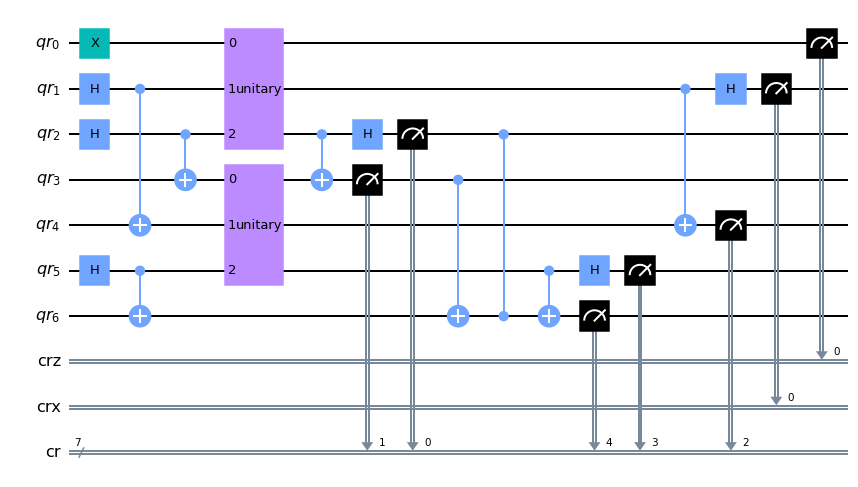

In [194]:
alice_initital_state = "1"

# set number of qubits
n = 7
# circ
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
cr = ClassicalRegister(n, name="cr")
qr = QuantumRegister(n, name="qr")
circ = QuantumCircuit(qr, crz, crx, cr)

# structure
bell_pairs = get_bell_pairs(circ)
# upper and lower half inums
fst_half =  [x for x in range(int(len(circ.qubits)/2))]
sec_half = [x for x in range(int(len(circ.qubits)/2),len(circ.qubits)-1)]
# pairs for mesurements
basemeas = bell_pairs[0]
bob_pair = bell_pairs[-1]
# inums for results
meas_a_i, meas_b_i = -1 * (basemeas[0]+1), -1 * (basemeas[1]+1)
bob_imeas, bob_pmeas = 0,1

# Create random 1-qubit state
from qiskit_textbook.tools import random_state
from qiskit.extensions import Initialize
psi = random_state(1)
init_gate = Initialize(psi)
init_gate.label = "init"
inverse_init_gate = init_gate.gates_to_uncompute()


################################################## APPLY PROTOCOL


# initialice alice in |psi>
#circ.append(init_gate, [0])
circ.x(0)
    
# entangle middle EPR pair and bobs EPR pair
entangle_bell_pairs(circ, [[1,4],[2,3],[5,6]])

# apply U
circ.append(Us_op, fst_half)
# apply U*P
circ.append(U_star_P, sec_half)

# epr measurement
#circ.cx(2,3)
#circ.h(2)
#circ.measure(2, crz)
#circ.measure(3,crx)

insert_bell_measurement(circ, [2,3])

circ.cx(3,6)
circ.cz(2,6)
# bob inverse gate
#circ.append(inverse_init_gate, [6])

insert_bell_measurement(circ, [5,6])
insert_bell_measurement(circ, [1,4])

circ.measure(0,0)

circ.draw('mpl', plot_barriers = False)

In [195]:
# run on simulator
be = f_alma
pct = 100
shots = 100*pct

qasm_sim = Aer.get_backend('qasm_simulator')
t_qc = transpile(circ, qasm_sim)
qobj = assemble(t_qc, shots=shots)

counts = qasm_sim.run(qobj).result().get_counts()
plot_histogram(counts)

result = be.run(qobj).result()
counts = dict(zip(
    [''.join([x for x in reversed(k[:7])]) for (k,v) in  result.get_counts().items()],  # inums reversed in measurement data 
    [v for (k,v) in  result.get_counts().items()]
))

num_of_1_states = get_exited_state_dist(result, num_qubits=7)


 Fidelity Bob Qubit:   	 49.57%

 meas_0 fidelity: 	 1.92 %

 meas_5 fidelity: 	 0.0 %

 meas_1 fidelity: 	 2.96 %

 meas_4 fidelity: 	 2.84 %

 meas_2 fidelity: 	 3.09 %

 meas_3 fidelity: 	 2.98 %



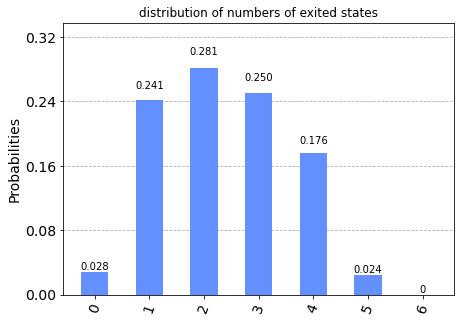

In [196]:
# see results 
bob_fid  = sum([v for (k,v) in counts.items() if k[-1]== alice_initital_state])
print("\n Fidelity Bob Qubit:   \t {}%".format(bob_meas_1/pct)) 

meas_0  = sum([v for (k,v) in counts.items() if k[0]== alice_initital_state])
meas_5  = sum([v for (k,v) in counts.items() if k[5]== alice_initital_state])
meas_1  = sum([v for (k,v) in counts.items() if k[1]== alice_initital_state])
meas_4  = sum([v for (k,v) in counts.items() if k[4]== alice_initital_state])
meas_2  = sum([v for (k,v) in counts.items() if k[2]== alice_initital_state])
meas_3  = sum([v for (k,v) in counts.items() if k[3]== alice_initital_state])

for meas in [['meas_0',meas_0], ['meas_5',meas_5],['meas_1',meas_1], ['meas_4',meas_4], ['meas_2',meas_2], ['meas_3',meas_3]]:
    print("\n", meas[0], "fidelity: \t", meas[1]/pct, "%") 

print()
plot_histogram(num_of_1_states, title = "distribution of numbers of exited states")

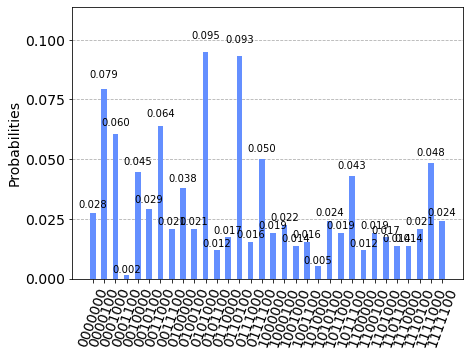

In [197]:
plot_histogram(counts)

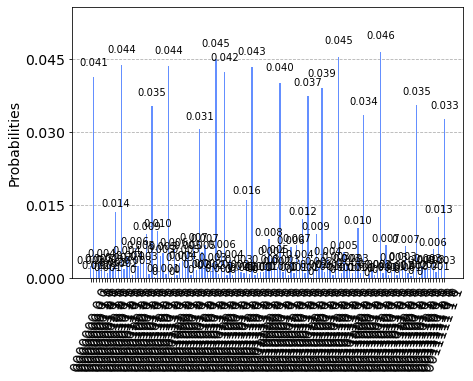

In [198]:
plot_histogram(result.get_counts())